In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
from functools import partial
import pickle
from gensim import corpora, models
from gensim.models import word2vec
import xgboost as xgb 
%matplotlib inline

/home/digitman/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/digitman/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD

Using Theano backend.


In [3]:
data = pd.read_csv('data/comments_vrn.csv.gz')

In [137]:
data.shape

(185612, 6)

In [5]:
data.is_gum.value_counts()

0.0    98373
1.0    87239
Name: is_gum, dtype: int64

In [6]:
data.sex = data.sex == 2
data.sex = data.sex.apply(int)

In [7]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,9048238,Вжух даже здесь,0.0,20,1,1
1,9048238,И пишите аккуратнее 😞,0.0,12,3,1
2,9048238,Это #имбрина 😏,0.0,21,0,1


### Length of comments (symbols)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185612 entries, 0 to 185611
Data columns (total 6 columns):
from_id    185612 non-null int64
text       185612 non-null object
is_gum     185612 non-null float64
hour       185612 non-null int64
likes      185612 non-null int64
sex        185612 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 8.5+ MB


In [9]:
lenghts_symb = np.array([len(m) for m in data.text.values])

In [10]:
lenghts_symb.mean(), np.median(lenghts_symb)

(77.209038208736501, 47.0)

In [11]:
min(lenghts_symb), max(lenghts_symb)

(1, 9947)

In [12]:
sum(lenghts_symb)

14330924

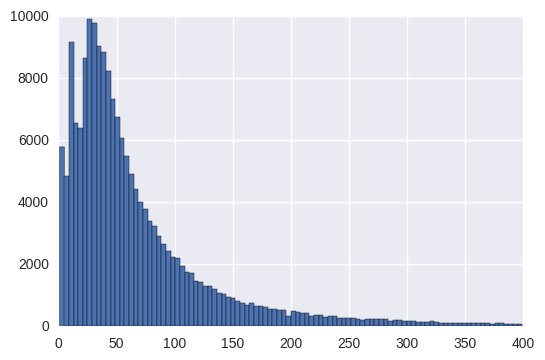

In [13]:
plt.hist(lenghts_symb[lenghts_symb < 400], bins=100);

In [14]:
print('{:.2f}% of comments are shorter than {} symbols'
      .format(lenghts_symb[lenghts_symb < 400].shape[0] / lenghts_symb.shape[0] * 100, 500))

98.39% of comments are shorter than 500 symbols


In [15]:
print('{:.2f}% of comments are longer than {} symbols'
      .format(lenghts_symb[lenghts_symb > 15].shape[0] / lenghts_symb.shape[0] * 100, 15))

86.62% of comments are longer than 15 symbols


### Length of comments (words)

In [16]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [17]:
lenghts_word.mean(), np.median(lenghts_word)

(11.451069973924099, 7.0)

In [18]:
min(lenghts_word), max(lenghts_word)

(1, 1612)

In [19]:
sum(lenghts_word) # total words

2125456

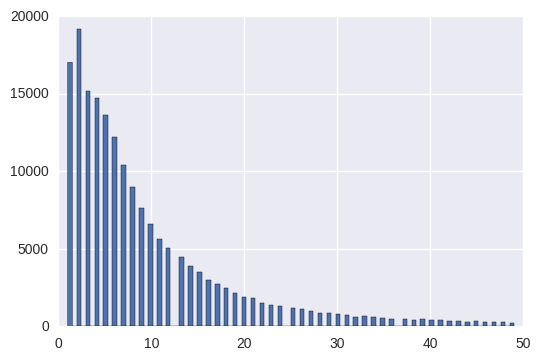

In [20]:
plt.hist(lenghts_word[lenghts_word < 50], bins=100);

In [21]:
print('{:.2f}% of comments are shorter than {} words'
      .format(lenghts_word[lenghts_word < 50].shape[0] / lenghts_word.shape[0] * 100, 50))

97.21% of comments are shorter than 50 words


In [22]:
print('{:.2f}% of comments are longer than {} words'
      .format(lenghts_word[lenghts_word > 4].shape[0] / lenghts_word.shape[0] * 100, 4))

64.36% of comments are longer than 4 words


### Count of unique (words)

In [23]:
words_ = np.array([m.split() for m in data.text.values])

In [24]:
words = []
for w in words_:
    words.extend(w)

In [25]:
len(words)

2125456

In [26]:
len(set(words))

366242

### Links

In [27]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 

In [28]:
links[:5]

['[id8407059|Евгений], во-первых, по цены. http://market.yandex.ru/search.xml?hid=91709&text=%D1%81%D1%87%D0%B5%D1%82%D1%87%D0%B8%D0%BA%20%D0%B3%D0%B0%D0%B7%D0%B0&srnum=117&ortext=%D1%81%D1%87%D0%B5%D1%82%D1%87%D0%B8%D0%BA%20%D0%B3%D0%B0%D0%B7%D0%B0 во-вторых, даже при отсутствии газонагревательных приборов разница расхода может составлять разы. Моя мать, например, любит газовой плитой кухню отапливать. В-третьих, тебя не смущает то, что электросчетчики ставили и ставят на любых потребителей, будь там хоть сортир с лампочкой? Ты просто не привык к этому, посему - возражаешь. А наличие прибора учета - это правильно. И ставят его, кстати, далеко не на один год. У нас уже лет 10 стоит.',
 '[id212860568|Дмитрий], ну измерь сам. Будешь удивлен http://maps.yandex.ru/?ll=39.211973%2C51.573975&spn=0.184536%2C0.086108&z=13&l=sat%2Cskl',
 '[id10072765|Александр], ты еще дрессировщика дрожжевых бактерий Жданова вспомни. Тоже "авторитет". с тем же успехом я тебе могу ответить этим: http://zenslim.

In [29]:
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.54% of comments contain links


## Preprocessing

### Dropping short and long

In [30]:
comments = data[(lenghts_word < 50) & (lenghts_word > 4)]

In [31]:
comments.shape

(114275, 6)

### Dropping with spam

In [32]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True for c in comments.text.values] 

In [33]:
comments = comments[without_link]

In [34]:
comments.shape

(113709, 6)

In [35]:
comments_lenghts = np.array([len(m) for m in comments.text.values])

In [36]:
comments_lenghts.argsort()[:10]

array([63201, 31809, 31729, 51659, 31418, 12582, 64250, 31876, 31761, 31765])

In [37]:
comments.text.values[21846]

'[id16867860|Дмитрий], басс должен давить душу 😃'

### Make class balanced

In [38]:
comments_ = comments.copy()

In [39]:
comments_vc = comments.is_gum.value_counts()
comments_vc

0.0    61145
1.0    52564
Name: is_gum, dtype: int64

In [40]:
delta = comments_vc[0] - comments_vc[1]
delta

8581

In [41]:
index_to_del = np.random.choice(comments[comments.is_gum == 0].index, delta, replace=False)
comments.drop(index_to_del, inplace=True)

In [42]:
comments.is_gum.value_counts()

1.0    52564
0.0    52564
Name: is_gum, dtype: int64

## Baseline

In [43]:
vectorizer = CountVectorizer(max_features=3000, ngram_range=(1, 3), analyzer='word', min_df=50)
X = vectorizer.fit_transform(comments.text.values)
y = comments.is_gum.values
# y = comments.sex.values

In [87]:
X.shape

(105128, 3000)

In [106]:
lr = lm.LogisticRegression()

In [107]:
np.random.seed(0)

In [90]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.51199475108081738, 0.0086975064694397031)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, comments.is_gum, test_size=0.2, random_state=0)

In [220]:
# X_train, X_test, y_train, y_test = train_test_split(word_features.toarray(), comments.is_gum, test_size=0.2, random_state=0)

In [92]:
X_train.shape, y_train.shape

((84102, 3000), (84102,))

In [93]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.56534766479596688

In [94]:
vectorizer.get_feature_names()[1565]

'не видели'

In [98]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 2000, 50)]

array(['за собой', 'для тебя', 'id283273320', 'подумал', 'года',
       'по факту', 'дмитрий да', 'которые не', 'автор', 'гг', 'на дорогах',
       'домой', 'каждый', 'как не', 'делают', 'каждого', 'дом',
       'id15892985 вячеслав', 'каждый день', 'есть', '150', 'долго',
       'будут', 'какое', '500', 'купить', 'конец', 'другом', 'бить',
       'кто на', 'не за', 'мороз', 'курсе', 'возможно', 'вроде бы',
       'не очень', 'более', 'машмет', 'да нет', 'долго', 'наше',
       'id173075801 никиняша', 'лучше не', 'пары', 'маршрутке', 'первого',
       'борис', 'мнения', 'интернет', 'город'], 
      dtype='<U29')

### NN

In [99]:
model = Sequential()
model.add(Dense(3000, input_shape=(3000,)))
model.add(Activation(PReLU()))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
%%time
history = model.fit(X_train.toarray(), y_train,
                    nb_epoch=10, batch_size=1024,
                    verbose=1, validation_split=0.1)

Train on 75691 samples, validate on 8411 samples
Epoch 1/10
75691/75691 [==============================] - 191s - loss: 0.6784 - acc: 0.5569 - val_loss: 0.6698 - val_acc: 0.5706
Epoch 2/10
75691/75691 [==============================] - 189s - loss: 0.6332 - acc: 0.6315 - val_loss: 0.6774 - val_acc: 0.5693
Epoch 3/10
75691/75691 [==============================] - 187s - loss: 0.5874 - acc: 0.6802 - val_loss: 0.6905 - val_acc: 0.5662
Epoch 4/10
75691/75691 [==============================] - 193s - loss: 0.5066 - acc: 0.7561 - val_loss: 0.7157 - val_acc: 0.5638
Epoch 5/10
75691/75691 [==============================] - 183s - loss: 0.4028 - acc: 0.8364 - val_loss: 0.7490 - val_acc: 0.5710
Epoch 6/10
75691/75691 [==============================] - 181s - loss: 0.3049 - acc: 0.8963 - val_loss: 0.7803 - val_acc: 0.5707
Epoch 7/10
75691/75691 [==============================] - 181s - loss: 0.2307 - acc: 0.9300 - val_loss: 0.8260 - val_acc: 0.5675
Epoch 8/10
75691/75691 [========================

In [102]:
score = model.evaluate(X_test.toarray(), y_test,
                       batch_size=512, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

21026/21026 [==============================] - 18s    
Test score: 0.97831793148
Test accuracy: 0.556881955663


### XGB

In [103]:
params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_matrics': 'error',
}

In [104]:
%%time
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

gbm = xgb.train(params, dtrain, 100, watchlist, verbose_eval=True, early_stopping_rounds=30)

[0]	train-error:0.482557	eval-error:0.486017
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 30 rounds.
[1]	train-error:0.476564	eval-error:0.481547
[2]	train-error:0.476077	eval-error:0.481023
[3]	train-error:0.472022	eval-error:0.478075
[4]	train-error:0.469894	eval-error:0.476696
[5]	train-error:0.468633	eval-error:0.475031
[6]	train-error:0.463544	eval-error:0.471369
[7]	train-error:0.46339	eval-error:0.471749
[8]	train-error:0.459371	eval-error:0.470037
[9]	train-error:0.459145	eval-error:0.470132
[10]	train-error:0.457171	eval-error:0.46861
[11]	train-error:0.45647	eval-error:0.468325
[12]	train-error:0.454734	eval-error:0.467802
[13]	train-error:0.445709	eval-error:0.462427
[14]	train-error:0.444234	eval-error:0.461334
[15]	train-error:0.443687	eval-error:0.461048
[16]	train-error:0.442558	eval-error:0.462142
[17]	train-error:0.441951	eval-error:0.461429
[18]	train-error:0.440346	eval-error:0.4

In [105]:
sorted(gbm.get_fscore().items(), key=lambda x: -x[1])[:5]

[('f1552', 177), ('f2869', 89), ('f1428', 87), ('f2945', 59), ('f2611', 53)]

In [108]:
list(filter(lambda x: x[1] == 1428, vectorizer.vocabulary_.items()))

[('на', 1428)]

In [110]:
pred = gbm.predict(dvalid)

In [111]:
pred

array([ 0.39265662,  0.53073764,  0.49504116, ...,  0.62434137,
        0.49504116,  0.49504116], dtype=float32)

In [112]:
accuracy_score(y_test, pred > 0.5)

0.55588319223818128

## Testing meta features

In [38]:
is_man = np.reshape((comments.sex == 2).astype('int'), (-1, 1))

/home/digitman/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [39]:
is_with_like = np.reshape((comments.likes > 0).astype('int'), (-1, 1))

/home/digitman/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [40]:
X = pd.get_dummies(comments.hour, prefix='h').values
X = np.hstack((X, is_with_like, is_man))

In [41]:
def get_meta_features():
    features = pd.DataFrame()
    features['is_man'] = comments.sex == 2
    features['is_with_like'] = comments.likes > 0
    features = pd.concat((features, pd.get_dummies(comments.hour, prefix='h')), axis=1)
    return features

In [42]:
meta_features = get_meta_features()

In [43]:
meta_features.head()

,is_man,is_with_like,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
6,False,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,False,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [46]:
baseline_scores = cross_val_score(lr, meta_features, comments.is_gum, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.53262276325052182, 0.007688754442077058)

## Emoji

In [43]:
comments_list = comments.text.values

In [44]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [45]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [46]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [47]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

In [48]:
get_emoji(' 🔥 🔥 👏')

['👏', '🔥', '🔥']

In [49]:
get_emoji(' 🔥 🔥 👏', False)

['👏', '🔥']

#### If not done before

In [56]:
%time emoji_from_comments_rep = list(map(get_emoji, comments_list))

CPU times: user 53min 46s, sys: 340 ms, total: 53min 47s
Wall time: 53min 50s


In [57]:
with open('emoji_from_comments_rep_vrn.pkl', 'wb') as f:
    pickle.dump(emoji_from_comments_rep, f)

#### Else load

In [50]:
with open('emoji_from_comments_rep_vrn.pkl', 'rb') as f:
    emoji_from_comments_rep = pickle.load(f)

In [51]:
emoji_from_comments_no_rep = list(map(lambda com: get_emoji(com, False), comments_list))

In [52]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

In [53]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'])

array([ 1.])

In [54]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'], repetition=False)

array([ 0.6])

In [55]:
em_proportion_rep = get_emoji_proportion(comments_list, emoji_from_comments_rep)

In [56]:
em_proportion_no_rep = get_emoji_proportion(comments_list, emoji_from_comments_no_rep)

### With repetition

In [57]:
(em_proportion_rep > 0.25).sum()

69

In [58]:
comments_list[em_proportion_rep > 0.25][:20]

array(['А в чем красота Дон умирает 😞',
       'Возвращаемся в старые времена 😂😂😂😂😂',
       'Какая красота 👍👍👍👍👍👍👍с страшно аж 😂😂😂',
       'Да мне то что я в душе всегда ребенок 😂😂😂😂😂',
       'Какая жесть у нас твориться)))',
       'Уехала в Воронеж попала в Пермь)) 😂😂',
       '😂😂😂😂духота че еще ему делать то... 😂😂😂',
       '[id26387325|Макс], а там темно и страшно 😂😂😂😂😂',
       '[id287521035|Алексей], 😂😂😂😂👍👍👍Нну вот ы самый раз)))',
       '[id281896850|Вадим], Спасибо что все таки согласились...',
       '[id16867860|Дмитрий], Да да мы такие 😀😀',
       'Я сегодня столько потяпала ребят... И ни чуть не устала 😂😂😂😂😂',
       '[id139027420|Анастасия], друга искать надо... Не то время 😂😂😂👍',
       '😂😂😂😂😂👍👍👍👍👍вот те на царица прям',
       'Ну ребят сами напросились.... 😂😂😂',
       'Как то тухло здесь сегодня)))',
       '[id281134594|Сергей], о чем я говорю???',
       '[id16867860|Дмитрий], у тебя научилась 😂😂😂',
       'Фу фу фу😂😂😂профессия сложнее чем на шахте наверное',
   

### Without repetition

In [59]:
(em_proportion_no_rep > 0.1).sum()

97

In [60]:
comments_list[em_proportion_rep > 0.1][:20]

array(['А в чем красота Дон умирает 😞',
       'Возвращаемся в старые времена 😂😂😂😂😂',
       'Помню раньше в школе на практике полоть их ходили 😂😂поэтому любви к ним не испытываю 😂😂😂',
       '[id152423768|Адриан], Да все отлично 👍👍👍',
       'Главное чтоб не поздно 😂😂😂👍', '😂😂😂это я с Перми возвращаюсь 😍😍',
       'Вот это да)))) красота прям 😍😍😍😍',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '😂😂😂😂😂это еще что такое 😂😂😂😂😂👍👍👍',
       'Какая красота 👍👍👍👍👍👍👍с страшно аж 😂😂😂',
       'Да мне то что я в душе всегда ребенок 😂😂😂😂😂',
       'Вот и здорово что такое лето.... Блин я все это пропустила 😂😂😂😂',
       'Спокойная атмосфера прям для отдыха...',
       'Какая жесть у нас твориться)))',
       'Уехала в Воронеж попала в Пермь)) 😂😂',
       '😂😂😂😂духота че еще ему делать то... 😂😂😂',
       'Ух ты 😍😍😍😍👍👍👍ВВОРОНЕЖ САМЫЙ ЛУЧШИЙ ГОРОД НА ЗЕМЛЕ 👍👍👍👍👍👍👍👍👍💋💋💋💋💋',
       'Там совсем не страшно)))  и в темноте тампрекрасно 😂😂😂😂',
       'Ммм молодцы люди отдыхают... 😍😍😍😍😍',
    

### Proportion of alphabetical symbols

In [61]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [62]:
abc_proportion = get_abc_proportion(comments_list)

In [63]:
abc_proportion[:10]

array([ 0.87179487,  0.81818182,  0.88842975,  0.87711864,  0.93939394,
        0.90909091,  0.79032258,  0.88202247,  0.6744186 ,  0.82242991])

In [64]:
sum(abc_proportion < 0.4)

273

In [65]:
comments_list[abc_proportion < 0.4][:20]

array(['+7 952 104 73 50', 'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '[id179033694|Анна], пободрей говоришь, ну лови\n ))))))))))))))))))))))))))))))))))',
       '[id16867860|Дмитрий], 19 мая, в 20:15',
       'Вариант на работе:\n\n4.0. Введение......................................................117',
       '[id213017431|Asmik], п. 4.1 п. 4.3 п.4.6 (!!!!)',
       'Радуйтесь :-D\n21.03 -1°..-3° Снег\n22.03 -6°..-8° Пер. облачность\n23.03 -8°..-10° Снег\n24.03 -6°..-8° Снег\n25.03 -5°..-7° Пер. облачность',
       '4я - 11% из них "+" 8% "-" 3%',
       '[id19704075|Мария], :-) ;-) :-D :-[ :-\\\nДостаточно?',
       '😆 😆 😆 😆 😆 😆 😆 😆 😆 😆', '😂 😂 😂 😂 😂', '8 950 762 98 65 Ждёмс)',
       '[id7446980|Алёна], 😐 😕 😟 😟', 'Катаюсь. 8960 119 91 54',
       '8, +7 (удивил, да? 😆)\n9601113330',
       '[id218830909|Анастасия], а 18 есть ?)))))))))))))))))))))',
       '8 915 552 13 72', '8 952 594 59 50', '8 952 594 69 50',
       '8 952 594 69 50'], dtype=object)

### Filling DataFrame

In [66]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments_rep]

ValueError: Length of values does not match length of index

In [ ]:
comments['em_proportion_rep'] = em_proportion_rep

In [ ]:
comments['em_proportion_no_rep'] = em_proportion_no_rep

In [ ]:
comments['abc_proportion'] = abc_proportion

In [ ]:
comments.head(5)

#### If message repeats more than one time - drop (spam)

In [ ]:
print('{} different spam comments'.format((comments.text.value_counts() > 1).sum()))

In [ ]:
print('{} total count of spam comments'
      .format(comments.text.value_counts()[comments.text.value_counts() > 1].values.sum()))

### Dropping outlier

In [ ]:
spam_comments = comments.text.value_counts()[comments.text.value_counts() > 1].keys()

In [ ]:
comments = comments[comments.text.apply(lambda t: t not in spam_comments)]

In [ ]:
index_to_del = comments[(comments.em_proportion_rep > 0.25) | (comments.abc_proportion < 0.4) | 
                        (comments.text.value_counts() != 1)].index

In [ ]:
index_to_del.shape

In [ ]:
comments.drop(index_to_del, inplace=True)

In [ ]:
comments.shape

In [ ]:
comments_list = comments.text.values

### Replacing id

In [ ]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'adddresssation'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('adddresssation')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))
comments_list = np.array(comments_list)

In [ ]:
comments_list[:5]

In [ ]:
comments_lenghts = np.array([len(m) for m in comments_list])

## Clearing comments

In [71]:
from sklearn import ensemble


In [72]:
y = comments.is_gum.values

In [73]:
adj_proportion = []

In [74]:
errors = []

In [67]:
def clear_comments(comments, with_stemmer=False, with_lemmer=True, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    global adj_proportion
    global errors 
    adj_proportion = []
    errors = []
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    names_del = 0
    i = -1
    for comment in comments:
        comment_ = comment
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            parsed = [lemmer.parse(c)[0] for c in comment]
            comment = [p.normal_form for p in parsed]
            adj = sum([1 for p in parsed if 'ADJ' in str(p.tag)])
            if len(comment) == 0:
                errors.append(comment_)
                adj_proportion.append(0)
            else:
                adj_proportion.append(adj / len(comment))
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments_rep[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

### Char

In [124]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=2, with_emoji=False, with_stemmer=False,
                            with_lemmer=False, without_names=True, without_stop_words=False)

names del: 0
CPU times: user 1.86 s, sys: 8 ms, total: 1.87 s
Wall time: 1.87 s


In [125]:
clear_coms[10:15]

['adddresssation вот это номер давайте вы свалите куда-нибудь из нашего дома или не будете давать идиотских советов это мой дом ничуть не меньше чем ваш мне неприятно нем видеть интерьеры века',
 'adddresssation про это тому подобное',
 'adddresssation что все молоко вашу группу не назвал не собирался прочитайте еще раз если не поняли мою мысль',
 'adddresssation ваше воинство вы ком солдатах вы это серьезно',
 'adddresssation потом попов на фонарях вешали причем не чекисты отнюдь будем мерятся пиписьками']

In [126]:
%%time
vectorizer = CountVectorizer(max_features=1000, min_df=50, ngram_range=(3, 3), analyzer='char_wb')
char_features = vectorizer.fit_transform(clear_coms)

CPU times: user 8.87 s, sys: 48 ms, total: 8.92 s
Wall time: 8.95 s


In [127]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 50)]

array([' об', 'реб', 'ты ', ' ув', 'ый ', 'поп', 'орм', 'сов', 'иво',
       'им ', 'спо', ' сн', 'ьно', 'акт', 'поп', 'ро ', 'ога', 'tio',
       'три', 'зат', 'вый', 'чит', 'вин', 'она', 'нят', 'льк', 'ль ',
       'оск', 'бя ', 'аве', 'оже', 'ку ', 'ину', 'тел', 'ало', ' до',
       'рое', ' ча', ' ча', 'учи', ' ку', 'той', 'лят', 'ке ', 'пор',
       'воз', 'ды ', 'ет ', 'нов', ' ил'], 
      dtype='<U3')

In [128]:
char_features.shape, comments.shape

((112676, 1000), (112676, 10))

In [130]:
np.mean(cross_val_score(lr, char_features, comments.is_gum, cv=5))

0.53209203190556964

### Word

In [144]:
rf = ensemble.RandomForestClassifier(n_jobs=-1)

In [68]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=False,
                            with_lemmer=True, without_names=True, without_stop_words=False)

names del: 53226
CPU times: user 11min 32s, sys: 8.34 s, total: 11min 41s
Wall time: 12min 3s


In [69]:
errors

['+7 952 104 73 50',
 '😆 😆 😆 😆 😆 😆 😆 😆 😆 😆',
 '😂 😂 😂 😂 😂',
 '8 915 552 13 72',
 '8 952 594 59 50',
 '8 952 594 69 50',
 '8 952 594 69 50',
 '8 952 594 69 50\n',
 '8 952 594 69 50',
 '8 952 594 69 50',
 '😊 😊 😊 😃 😊 😊 😊 😊',
 '😢 😢 😢 😢 😢',
 '😢 😢 😢 😢 😢 😢',
 '😍 😍 😍 😍 😍 😍 😍 ❤',
 '😊 😊 😊 ❤ ❤ ❤',
 '😍 😍 😍 😍 😍 👍 👍 👍 👍 👍 👍',
 '😍 😍 😍 😍 😍 😍 😍 😍 😊 👍 👍',
 '😆 😆 😆 😆 😆 😆',
 '😊 😊 😊 😊 😊 👍 👍 👍 👍 👍 👍',
 '👍 👍 👍 👍 👍 👍 😍 😍 😍 😍 😍',
 '😴 😴 😴 😴 😴 😴',
 '😍 😍 😍 😍 😍 😍 😍 😍',
 '👿 👿 👿 👿 👿',
 '💖 💖 💖 💖 💖 💖',
 '😍 😍 😍 😍 😍 😍 😍 😍',
 '😂 😂 😂 😂 😂 😂',
 '😍 😍 😍 😍 😍 😍',
 '👍 👍 👍 👍 👍 👍',
 '💃 💃 💃 💃 💃 💃 👯 👯 👯 👯 👯',
 '😊 😊 😉 💃 💃 💃 💃',
 '✌ ✌ ✌ ✌ ✌',
 '😍 😍 😍 😍 😍 😍',
 '✌ ✌ ✌ ✌ ✌',
 '✌ ✌ ✌ ✌ ✌ ✌',
 '✌ ✌ ✌ ✌ 😜 😜 😊 😊 😊 😊 ✌ ✌ ✌',
 '8 915 228 14 88',
 '8 911 228 14 88',
 '8 810 777 14 88',
 '8 915 555 44 44',
 '8 905 722 67 53',
 '8 920 466 43 77',
 '8 920 466 43 77',
 '8 920 466 43 77',
 '8 951 546 71 17',
 '8 920 442 99 79',
 '919 236 36 35 =*',
 '919 236 36 35 ;)',
 '8 919 236 36 35  :3',
 '8 952 540 74 98',
 '8 952 540 74 98',
 '8 951 547 93 83',

In [102]:
clear_coms[10:15]

['adddresssation вот это номер давать свалить куда-нибудь наш дом или быть давать идиотский совет это мой дом ничуть маленький чем ваш неприятно немой видеть интерьер век',
 'adddresssation про это тот подобный',
 'adddresssation ваш воинство ком солдат это серьёзно',
 'adddresssation потом попов фонарь вешать причём чекист отнюдь быть мериться пиписька',
 'adddresssation слово строй слышать кстати как освящение ракета оружие смысл святой атомный бомба там пример']

In [123]:
adj_proportion[10:15]

[]

In [134]:
%%time
vectorizer = CountVectorizer(max_features=2000, min_df=50, ngram_range=(1, 3), analyzer='word')
word_features = vectorizer.fit_transform(clear_coms)

CPU times: user 15.6 s, sys: 192 ms, total: 15.8 s
Wall time: 15.9 s


In [135]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 20)]

array(['возле', 'моему', 'администрация', 'культурный', 'дверь',
       'adddresssation так это', 'adddresssation точно', 'мск', 'гораздо',
       'злой', 'зависеть', 'наверно', 'идти', 'нарушать',
       'adddresssation там', 'важный', 'вредный', 'кто хотеть', 'небо',
       'adddresssation надо'], 
      dtype='<U25')

In [136]:
word_features.shape

(112676, 2000)

In [137]:
char_features.shape, word_features.shape

((112676, 1000), (112676, 2000))

In [138]:
np.mean(cross_val_score(lr, word_features, comments.is_gum, cv=5))

0.52276429778394284

In [145]:
%%time
np.mean(cross_val_score(rf, word_features, comments.is_gum, cv=5))

CPU times: user 5min 58s, sys: 496 ms, total: 5min 58s
Wall time: 2min 1s


0.51699573984774205

## LSTM

In [85]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
np.random.seed(7)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(word_features.toarray(), comments.is_gum, test_size=0.2, random_state=0)

In [148]:
max_comment_length = 50
X_train = sequence.pad_sequences(X_train, maxlen=max_comment_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_comment_length)

In [166]:
X_train.sum(axis=1)[:20]

array([12,  7,  2, 10,  5, 25,  7, 12,  9, 17,  4,  3, 14,  5,  3,  5, 11,
        1,  4,  7], dtype=int64)

In [ ]:
%%time
# create the model
embedding_vector_length = 128
model = Sequential()
model.add(Embedding(word_features.shape[1], embedding_vector_length)) #, input_length=max_comment_length))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.2))
# model.add(LSTM(64))  # return a single vector of dimension 32
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=5, batch_size=256)

In [93]:
vects.shape[1]

43

In [95]:
%%time
# create the model
embedding_vector_length = 128
model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(43, 500)))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
# model.add(Dropout(0.2))
# model.add(LSTM(64))  # return a single vector of dimension 32
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(np.zeros(vects, np.zeros(1000)))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_4 (LSTM)                    (None, 128)           322048      lstm_input_4[0][0]               
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 1)             129         lstm_4[0][0]                     
Total params: 322177
____________________________________________________________________________________________________
None


ValueError: sequence too large; cannot be greater than 32

In [178]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 50.47%


## Models

In [ ]:
from sklearn import naive_bayes, neighbors, ensemble

In [78]:
lr = naive_bayes.MultinomialNB()

In [180]:
lr = ensemble.RandomForestClassifier(10, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [266]:
lr = ensemble.GradientBoostingClassifier()

In [89]:
lr = lm.LogisticRegression()

In [124]:
np.random.seed(0)

In [76]:
%%time
baseline_scores = cross_val_score(lr, word_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.516760322702 0.0102954889703
CPU times: user 5.72 s, sys: 4 ms, total: 5.72 s
Wall time: 5.72 s


In [77]:
%%time
baseline_scores = cross_val_score(lr, char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.529098666097 0.00914137273099
CPU times: user 37.9 s, sys: 156 ms, total: 38 s
Wall time: 38 s


In [101]:
from scipy import sparse

In [102]:
word_char_features = sparse.hstack((word_features, char_features))

In [103]:
word_char_features.shape

(111920, 2000)

In [81]:
%%time
baseline_scores = cross_val_score(lr, word_char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.528697488912 0.00809228277877
CPU times: user 45.8 s, sys: 172 ms, total: 45.9 s
Wall time: 45.9 s


In [81]:
%%time
lr.fit(X, y)

CPU times: user 8min 12s, sys: 144 ms, total: 8min 12s
Wall time: 2min 5s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
lr.score(X, y)

0.67386973776359815

In [83]:
lr.feature_importances_.argsort()[-10:]

array([648, 765, 206, 499, 182, 183, 106, 214, 306, 870])

In [408]:
lr.coef_.argmax()

462

In [84]:
vectorizer.get_feature_names()[648]

'прав'

In [85]:
for w in lr.feature_importances_.argsort()[-100:]:
    print(vectorizer.get_feature_names()[w])

куп
ваш
кажд
хочет
разн
сильн
групп
ответ
реальн
голов
равн
тво
собак
поэт
езд
красив
хотел
рук
вод
сраз
нужн
чита
еха
дет
главн
суд
автор
личн
никак
жизн
нет
больш
ноч
сторон
народ
писа
район
добр
врод
интересн
кстат
счита
утр
деньг
блин
перв
наверн
улиц
смотр
мог
муж
вопрос
плох
точн
поня
понима
час
прям
город
мест
девушк
работ
работа
знает
наш
жив
дава
водител
случа
фот
вид
пуст
видел
пост
ход
скор
сам
написа
зна
стран
человек
друг
что
нормальн
хорош
слов
говор
сто
сво
дорог
прав
сдела
дом
одн
дел
дела
вообщ
дума
как
так


### Is the first letter of sentence upper

In [76]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'adddresssation' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        sents_count.append(total)
    return big_letter, sents_count

In [77]:
print(re.match('.*[a-zа-яё].*', '', flags=re.IGNORECASE))

None


In [78]:
sentence_stat(comments_list[250:260])

([1, 0, 0, 1, 1, 1, 1, 0, 1, 1], [3, 1, 5, 3, 1, 3, 3, 4, 3, 2])

In [79]:
comments_list[355:360]

array([ 'adddresssation у берега? Конечно. Пол метра - максимум. Если бы не парапет - на таком расстоянии от уреза воды глубина обычно сантиметров 20...',
       'adddresssation я и не говорил, что там должно быть глубоко. Я написал, что посередине водохранки глубина редко превышает 3 метра.',
       'Типа, каждый год, 31-го декабря.... ?',
       'adddresssation неправильно. Это гонорея чужого. Или, более полно - центнер гонореи чужого.',
       'Сейчас самое время сказать: - Вот молодежь пошла! Вот в наше время!..'], 
      dtype='<U2376')

In [80]:
[list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', c))) for c in comments_list[350:360]]

[['adddresssation твой взгляд ласкают развалины и строительные леса?'],
 ['adddresssation ды ну?', 'В Воронеже нет казаков?', 'хе-хе!'],
 ['Россия-Латвия 6:0?',
  'Невероятный успех!',
  'Ну, если еще и Намибию победим!',
  ''],
 ['adddresssation течение?',
  'На водохранке?',
  'Ты это сейчас серьезно сказал?'],
 ['adddresssation средневзвешенная глубина водохранки около 3-х метров',
  'То есть, почти везде',
  'Есть несколько зимовальных ям глубже 20-и метров (расположены на старом русле реки',
  'Береговой откос отсутствует, дно очень пологое, то есть, глубина растет очень медленно - в 10 метрах от берега по колено',
  ''],
 ['adddresssation у берега?',
  'Конечно',
  'Пол метра - максимум',
  'Если бы не парапет - на таком расстоянии от уреза воды глубина обычно сантиметров 20',
  ''],
 ['adddresssation я и не говорил, что там должно быть глубоко',
  'Я написал, что посередине водохранки глубина редко превышает 3 метра',
  ''],
 ['Типа, каждый год, 31-го декабря', '?'],
 ['adddress

In [81]:
%%time
big_letter, sents_count = sentence_stat(comments_list)
big_letter = np.reshape(big_letter, (-1, 1))
sents_count = np.reshape(sents_count, (-1, 1))

CPU times: user 5.54 s, sys: 4 ms, total: 5.54 s
Wall time: 5.55 s


In [82]:
sents_count[350:360]

array([[1],
       [3],
       [3],
       [3],
       [4],
       [4],
       [2],
       [1],
       [3],
       [2]])

In [83]:
pd.Series(big_letter.ravel()).value_counts()

1    71053
0    34075
dtype: int64

In [84]:
baseline_scores = cross_val_score(lr, sents_count, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

NameError: name 'lr' is not defined

In [ ]:
comments['all_sent_upper'] = letters

In [ ]:
sns.countplot(x='all_sent_upper', hue='is_gum', data=comments)

### Punctuation count in comment

In [ ]:
def punctuation_counts(comments, pattern='\(+', partion=True):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) * 100 for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [ ]:
comments_list[:10]

In [ ]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=True)

In [ ]:
punctuation_counts(['he... w...'], pattern='[\.]{2,}', partion=True)

In [ ]:
commas[:10]

In [ ]:
pd.Series(commas).value_counts()

In [ ]:
commas = np.reshape(commas, (-1, 1))

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
lr = ensemble.RandomForestClassifier(10)

In [ ]:
baseline_scores = cross_val_score(lr, commas, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

In [ ]:
comments['commas'] = commas

In [85]:
sns.countplot(x='commas', hue='is_gum', data=comments)

ValueError: Could not interpret input 'commas'

### Mean word length

In [150]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [526]:
comments_list[35:40]

['Все вопросы к администратору магазина! Незнания порядка не дает права вам нарушать его а жалобу можно отдать как администратору так и директору или есть такая КНИГА ЖАЛОБ',
 'Сука 100 р по везету и Вы в любом конце',
 'Папа новые даст не переживай😀',
 'Это чисто две банды долбоебов как от факела так и от динамо',
 'Сердце Егора ухнуло в пятки.']

In [530]:
mean_length = mean_word_length(comments_list)
mean_length[35:40]

[5.296296296296297, 3.0, 4.8, 4.0, 4.6]

In [531]:
mean_length = np.reshape(mean_length, (-1, 1))

In [534]:
baseline_scores = cross_val_score(lr, mean_length, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.520029569683 0.0124683358375


### Caps WORD

In [151]:
def caps_words(comments, partion=True):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [152]:
caps = caps_words(comments_list, False)

In [143]:
comments_list[:10]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉',
 'adddresssation любое ДТП есть страховой случай! И будет оплачиваться в законном порядке... А как в тебя въехали не ИМЕЕТ ЗНАЧЕНИЯ!',
 'adddresssation что если кого то что то неустраевает пойти и решить проблему, а не писать в типичный что под их окнами газуют...У ВСЕХ ГАЗУЮТ',
 'Норма у всех своя, а правила регулируют закон... А если так то действуй а не ори что у тебя проблема',
 'adddresssation да будет так',
 'Для особо одаренных есть ночные смены😀']

In [144]:
caps[:10]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 0]

In [145]:
pd.Series(caps).value_counts()

0    124626
1      3884
dtype: int64

In [83]:
caps = np.reshape(caps, (-1, 1))

In [587]:
baseline_scores = cross_val_score(lr, caps, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.505563769356 0.0


### English words

In [153]:
def eng_words(comments, partion=True):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'adddresssation'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [154]:
engs = eng_words(comments_list, False)

In [103]:
pd.Series(engs).value_counts()

0    110549
1      1621
dtype: int64

In [617]:
engs = np.reshape(engs, (-1, 1))

In [619]:
lr = lm.LogisticRegression()

In [623]:
baseline_scores = cross_val_score(lr, engs, y, cv=10)
print(baseline_scores.mean(), baseline_scores.stdt())

0.505563769356 0.0


### All comments features together

In [155]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\)+', partion=False)
    features['punct_...'] = punctuation_counts(coms, pattern='\.\.\.', partion=False)
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms, True)
    features['em_proportion_rep'] = comments['em_proportion_rep'].values
    features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    return features

In [156]:
comment_features = get_comments_features(comments_list)

In [157]:
comment_features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_...,punct_?,punct_!,punct_..,punct_1-9,"punct_""",eng_words,mean_word_len,caps,em_proportion_rep,em_proportion_no_rep,adj_proportion,abc_proportion
count,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000
mean,0.086546,0.669578,1.784646,0.896777,0.249744,0.143824,0.434742,0.407384,0.848842,0.513379,1.419241,0.242001,4.726950,0.421457,0.002817,0.002049,0.095742,0.837275
std,0.281170,0.470367,1.177020,2.280447,0.432867,0.350913,1.205701,1.578833,2.350799,2.125769,7.959314,2.851777,0.958116,3.692291,0.013103,0.008321,0.096758,0.112517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.400000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.125000,0.000000,0.000000,0.000000,0.000000,0.754717
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.666667,0.000000,0.000000,0.000000,0.086957,0.857143
75%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.266667,0.000000,0.000000,0.000000,0.153846,0.933333
max,1.000000,1.000000,21.000000,53.061224,1.000000,1.000000,53.448276,38.775510,44.660194,45.833333,100.000000,110.000000,20.571429,120.000000,0.250000,0.250000,1.000000,1.000000


## word2vec

In [70]:
model_web = word2vec.Word2Vec.load_word2vec_format('../RussianHorrorStories/models_bin/web.model.bin', binary=True)

In [71]:
def get_vector_from_words(words, model, num_features):
    features = np.zeros((num_features,), dtype=np.float32)
    n = 0
    index2word = set(model.index2word)
    
    for word in words:
        if word in index2word:
            features += model[word]
            n += 1
    return features / n

In [128]:
model_web.similar_by_vector(np.zeros(500))

[('поскок_S', 0.0),
 ('збираємо_UNKN', 0.0),
 ('потыкаться_V', 0.0),
 ('дауыст_S', 0.0),
 ('Медвідь_UNKN', 0.0),
 ('замкнут_S', 0.0),
 ('соман_S', 0.0),
 ('Moneyman_UNKN', 0.0),
 ('энергопотеря_S', 0.0),
 ('бха_S', 0.0)]

In [139]:
model_web.similar_by_vector(np.array([0.00001] * 500))

[('убивашка', 0.19292950630187988),
 ('арта', 0.19121873378753662),
 ('правдивость', 0.18544238805770874),
 ('родео', 0.18539626896381378),
 ('анимус', 0.1840219497680664),
 ('фуфик', 0.18241336941719055),
 ('Ozma', 0.1823888123035431),
 ('гамать', 0.1819078028202057),
 ('сесиль', 0.17944177985191345),
 ('соника', 0.17903569340705872)]

In [78]:
def get_texts_vectors_long(texts, model, num_features=500):
    max_len = max([len(w.split()) for w in texts])
    texts_vectors = np.zeros((len(texts), max_len, num_features), dtype=np.float32)
    index2word = set(model.index2word)
    i = 0
    for text in texts:
        words = text.split()
        features = np.zeros((max_len, num_features), dtype=np.float32)
        for j in range(max_len):
            if j < len(words):
                word = words[j]
                if word in index2word:
                    features[j] = model[word]
                else:
                    features[j] = [0.1] * num_features
            else:
                features[j] = [0] * num_features
        texts_vectors[i] = features
        i += 1
    return texts_vectors

In [100]:
def get_texts_vectors(texts, model, num_features):
    texts_vectors = np.zeros((len(texts), num_features), dtype=np.float32)
    
    i = 0
    for text in texts:
        texts_vectors[i] = get_vector_from_words(text.split(), model, num_features)
        i += 1
    return texts_vectors

In [97]:
for i in range(len(model_web.index2word)):
    model_web.index2word[i] = re.split('_', model_web.index2word[i])[0]
model_web.vocab = {re.split('_', x[0])[0]: x[1] for x in list(model_web.vocab.items())}

In [98]:
clear_coms[30:35]

['что сделать небо убить совсем земля облить йад обработчик блин',
 'вообще-то проблема старый как существовать отнюдь только олимпик кстати лесна пейзаж распахнуть машина который литься поток музыка заставлять прохожий пригибаться лично вызывать желание воспользоваться огнемёт',
 'ноль как минимум дописать справа',
 'демьян звучать так как будто когда-то быть',
 'мизулин яров']

In [79]:
%%time
vects = get_texts_vectors_long(clear_coms[:1000], model_web, 500)

CPU times: user 1.52 s, sys: 56 ms, total: 1.58 s
Wall time: 1.58 s


In [101]:
%%time
vects = get_texts_vectors(clear_coms, model_web, 500)

CPU times: user 1h 56min 30s, sys: 1.67 s, total: 1h 56min 32s
Wall time: 1h 56min 38s


In [102]:
for vec in vects[30:35]:
    print(model_web.similar_by_vector(vec, 5))

[('небо', 0.580722451210022), ('блин', 0.552096426486969), ('земля', 0.5153524875640869), ('йад', 0.4994463324546814), ('складывай', 0.49854451417922974)]
[('информайция', 0.644280731678009), ('складывай', 0.6402790546417236), ('естественно', 0.6106724739074707), ('хотя', 0.6101795434951782), ('вернее', 0.6065548062324524)]
[('ноль', 0.716782808303833), ('минимум', 0.6825624704360962), ('справа', 0.5531907081604004), ('максимум', 0.43939173221588135), ('примерно', 0.42912623286247253)]
[('когда-то', 0.6720130443572998), ('звучать', 0.6657713651657104), ('демьян', 0.6282759308815002), ('слышать', 0.5373185873031616), ('кажется', 0.5274097919464111)]
[('яров', 0.7704957723617554), ('мизулин', 0.7704957723617554), ('андреев', 0.470670223236084), ('яковлев', 0.4682459831237793), ('миронов', 0.46809446811676025)]


In [103]:
index_to_del = comments[(np.isnan(vects).sum(axis=1) != 0)].index

In [104]:
index_to_del.shape

(1488,)

In [106]:
comments.drop(index_to_del, inplace=True)
comments_list = comments_list[np.isnan(vects).sum(axis=1) == 0]
vects = vects[np.isnan(vects).sum(axis=1) == 0]

In [107]:
y = comments.is_gum.values

In [108]:
lr = lm.LogisticRegression()

In [109]:
%%time
baseline_scores = cross_val_score(lr, vects, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.524488706645 0.0148358171696
CPU times: user 50.2 s, sys: 3.21 s, total: 53.4 s
Wall time: 52.1 s


## LDA

## Filtering dictionary

In [110]:
import copy

In [111]:
splited_coms = [com.split() for com in clear_coms]
dictionary = corpora.Dictionary(splited_coms)
corpus = [dictionary.doc2bow(com) for com in splited_coms]
print(dictionary.filter_extremes())

Dictionary(58501 unique tokens: ['хололном', 'фааак', 'одногруппница', 'давний', 'спец']...)


In [112]:
dictionary_filtered = copy.deepcopy(dictionary)
dictionary_filtered.filter_extremes(no_below=10, no_above=0.5)

In [113]:
with open('names_from_sent.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]
names_ids = []
for name in names:
    try:
        names_ids.append(dictionary_filtered.token2id[name])
    except:
        pass
dictionary_filtered.filter_tokens(bad_ids=names_ids)

In [114]:
print(dictionary_filtered)

Dictionary(8347 unique tokens: ['растаять', 'уничтожение', 'спец', 'замолчать', 'чужое']...)


In [115]:
dict_count_before= len(dictionary)
corpus_size_before = sum([word[1] for document in corpus for word in document])
corpus = [dictionary_filtered.doc2bow(text) for text in splited_coms]
dict_count_after = len(dictionary_filtered)
corpus_size_after = sum([word[1] for document in corpus for word in document])

In [116]:
print('Dictionary size\nBefore: {}; after: {}\nCorpus size\nBefore: {}; after: {}'.format(
      dict_count_before, dict_count_after, corpus_size_before, corpus_size_after))

Dictionary size
Before: 58501; after: 8347
Corpus size
Before: 994217; after: 877252


In [117]:
dictionary_filtered.save('models_bin/dictionary_filtered')

### Model

If already trained before

In [ ]:
%%time
dictionary_filtered = corpora.Dictionary.load('models_bin/dictionary_filtered')
splited_texts = [text.split() for text in stemmed_posts_texts]
corpus = [dictionary_filtered.doc2bow(text) for text in splited_texts]

In [135]:
%%time
ldamodel = models.LdaModel(corpus, id2word=dictionary_filtered, num_topics=30, passes=50,
                           alpha='auto') #, eta='auto')

CPU times: user 2h 40min 5s, sys: 8.97 s, total: 2h 40min 14s
Wall time: 2h 39min 52s


In [136]:
ldamodel.save('models_bin/lda')

In [ ]:
ldamodel = models.LdaModel.load('models_bin/lda')

In [138]:
for i, topic in ldamodel.show_topics(num_topics=30, num_words=5, formatted=False):
    print("Topic " + str(i) + ': ')
    for word, p in topic:
        print(word, p)

Topic 0: 
без 0.0718226942169
смотреть 0.0666274130259
потом 0.0558065016286
дорога 0.0467923429886
добрый 0.0395912953737
Topic 1: 
стоить 0.0535455563272
чтоб 0.0351202544069
равно 0.0341401297865
купить 0.0338601259306
искать 0.0301445600767
Topic 2: 
делать 0.106118730832
любить 0.0679756310156
ребята 0.0583875647154
😂 0.0477172890378
сразу 0.0461039155584
Topic 3: 
день 0.11503162186
народ 0.0521156687068
завтра 0.0382764184161
либо 0.035803039892
школа 0.0331886586876
Topic 4: 
😊 0.118553279796
после 0.0506758166839
вопрос 0.0499725438441
😆 0.047072175996
точно 0.0439243443499
Topic 5: 
теперь 0.0724381435964
под 0.0625424225844
спасибо 0.0488356349831
помочь 0.0345757706072
вода 0.0322008343262
Topic 6: 
кто 0.145969699612
тот 0.138255865424
знать 0.0922734316054
себя 0.0771871429625
сам 0.0675566963476
Topic 7: 
что 0.0973130365539
это 0.0856465083512
быть 0.0685604213608
весь 0.0671113939404
как 0.0479693266572
Topic 8: 
дом 0.0802775574164
твой 0.0678758111152
найти 0.0586435

In [139]:
clear_coms[1]

'они кагбэ намекать что накручивать левый платёж очень много сука они весь'

In [143]:
ldamodel.get_document_topics(list(corpus)[6], minimum_probability=0.05)

[(7, 0.25796198857235919)]

In [131]:
topic = ldamodel.show_topic(9, 10)
for word, p in topic:
    print(word, p)

что 0.0921450878105
это 0.0810981101429
быть 0.0649193791503
весь 0.0635473022757
как 0.0454217737453
так 0.0426841143877
такой 0.0329708574342
они 0.0316512586539
если 0.0268553149246
вот 0.0253401273349


In [273]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

282.892353183


In [277]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

172.318180434


## Getting LDA Feature matrix

In [ ]:
splited_train_texts = [text.split() for text in x_train]
corpus_train_dataset = [dictionary_filtered.doc2bow(text) for text in splited_train_texts]

In [167]:
def get_corpus_matrix(model, corpus):
    matrix = np.zeros((len(corpus), model.num_topics))
    for i in range(len(corpus)):
        doc_topics = model.get_document_topics(list(corpus)[i], minimum_probability=0.05)
        for topic_id, prob in doc_topics:
            matrix[i, topic_id] = prob
    return matrix

In [169]:
%%time
X_lda = get_corpus_matrix(ldamodel, corpus)

CPU times: user 9min 38s, sys: 300 ms, total: 9min 38s
Wall time: 9min 38s


In [170]:
X_lda.shape

(111920, 50)

In [230]:
comments.shape

(111920, 10)

In [125]:
lr = lm.LogisticRegression()

In [231]:
%%time
baseline_scores = cross_val_score(lr, X_lda, comments.is_gum, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.509935668335 0.00745228690032
CPU times: user 1.7 s, sys: 1.85 s, total: 3.54 s
Wall time: 2.17 s


## Final model

In [120]:
word_char_features.shape, comment_features.shape # meta_features.shape

((111920, 2000), (111920, 18))

In [121]:
X = np.hstack((word_char_features.toarray(), comment_features.values))

In [122]:
X.shape

(111920, 2018)

In [90]:
y = comments.is_gum.values

In [112]:
lr = lm.LogisticRegression()

In [165]:
lr = naive_bayes.MultinomialNB()

In [124]:
lr = ensemble.RandomForestClassifier(20, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [189]:
lr = ensemble.GradientBoostingClassifier()

In [190]:
np.random.seed(0)

In [97]:
baseline_scores = cross_val_score(lr, X, y, cv=3)
print(baseline_scores.mean(), baseline_scores.std())

0.521181838852 0.0138376103516


## Testing on human

In [106]:
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

In [107]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [138]:
s = StratifiedShuffleSplit(y, n_iter=1, test_size=20, random_state=0)

In [139]:
index_test = []

In [140]:
for train, test in s:
    index_test = test
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

In [141]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
prediction = lr.predict_proba(X_test)[:, 1]

In [143]:
accuracy_score(y_test, prediction)

0.34999999999999998

In [144]:
ans = []
for comment in comments_list[index_test]:
    a = input(comment)
    ans.append(int(a))

Так у них же пллан какой то есть, типа стоять на всех главных перекрестках0
Только ковры на стены вешать, иначе слышно все1
adddresssation о, спасибо чувак, и тебе зачёт великий! Хоть кто-то знает, насколько клёвая штука - осциллограф!0
adddresssation Даже сапер имеет право на ошибку...Так вот...Я не он1
adddresssation я не говорила что нет обработки. фотошоп исправляет недостатки, а здесь просто улучшено качество самой фотографии.1
adddresssation мне не нужен допинг чтобы источать радость и хорошее настроение ☺1
adddresssation ну это да. было бы желание.0
adddresssation Вы имели ввиду "никто не шутит"0
adddresssation Самвел армянское имя и к Махачкалинской области РФ(Дагестану) никакого отношения не имеет1
В 6 движуха уже во всю0
adddresssation Замена заявленного кондидата в олимпийских игр происходит как минимум за 3 дня и то по травме))1
Посмотреть что ли в окно0
adddresssation согласна, некоторые дети бросают своих стариков 😔1
Пересматриваю все части, чтобы пойти на 7ю подготовленн

In [145]:
sum(ans)

12

In [146]:
len(ans)

20

In [147]:
accuracy_score(y_test, ans)

0.69999999999999996

In [150]:
y_test = [int(y) for y in y_test]
prediction = [int(p) for p in prediction]

In [153]:
list(zip(comments_list[index_test], y_test, prediction, ans))

[('Так у них же пллан какой то есть, типа стоять на всех главных перекрестках',
  0,
  0.51186352495835707,
  0),
 ('Только ковры на стены вешать, иначе слышно все', 0, 0.51120625719204627, 1),
 ('adddresssation о, спасибо чувак, и тебе зачёт великий! Хоть кто-то знает, насколько клёвая штука - осциллограф!',
  0,
  0.37807061591042296,
  0),
 ('adddresssation Даже сапер имеет право на ошибку...Так вот...Я не он',
  1,
  0.54625583923717969,
  1),
 ('adddresssation я не говорила что нет обработки. фотошоп исправляет недостатки, а здесь просто улучшено качество самой фотографии.',
  1,
  0.42449077280158115,
  1),
 ('adddresssation мне не нужен допинг чтобы источать радость и хорошее настроение ☺',
  1,
  0.45122448038554991,
  1),
 ('adddresssation ну это да. было бы желание.', 1, 0.61851027790870372, 0),
 ('adddresssation Вы имели ввиду "никто не шутит"', 0, 0.52869545175277877, 0),
 ('adddresssation Самвел армянское имя и к Махачкалинской области РФ(Дагестану) никакого отношения не и